<center><b><h1> NLP Task </h1></b></center>

## Import Libraries

In [1]:
import nltk
import torch
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Download the NLTK stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the DistilBERT tokenizer and model

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Sentence tokenization and Stopword removal for each sentence

In [4]:
def preprocess(text):
    
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    # Remove stopwords from each sentence
    stop_words = set(stopwords.words('english'))
    preprocessed_sentences = []
    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence.lower())
        filtered_sentence = [word for word in tokens if word not in stop_words]
        preprocessed_sentences.append(' '.join(filtered_sentence))
    
    return preprocessed_sentences

## Sentence Similarity (Cosine Similarity)

In [5]:
def similar_sentences(sentence1, sentence2):
    # Tokenize and convert sentences to input tensors
    inputs = tokenizer([sentence1, sentence2], padding=True, truncation=True, return_tensors='pt')
    
    # Pass the input tensors through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the sentence embeddings from the model outputs
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    # Calculate cosine similarity between the sentence embeddings
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    
    return similarity

## Graph Construction

In [6]:
def graph_constructor(text, threshold):
    # Preprocess the text
    preprocessed_sentences = preprocess(text)
    
    # Create a graph
    graph = nx.Graph()
    
    # Add nodes to the graph
    graph.add_nodes_from(range(len(preprocessed_sentences)))
    
    # Calculate sentence similarity and add edges to the graph
    for i in range(len(preprocessed_sentences)):
        for j in range(i + 1, len(preprocessed_sentences)):
            similarity = similar_sentences(preprocessed_sentences[i], preprocessed_sentences[j])
            
            if similarity > threshold:
                graph.add_edge(i, j, weight=similarity)
    
    return graph

### Example

In [7]:
# Example usage
input_text = '''
This is the first sentence. 
Here is the second sentence. 
And this is the third sentence. 
Finally, the fourth sentence is here.
'''
threshold = 0.6

graph = graph_constructor(input_text, threshold)
print("Graph nodes:", graph.nodes())
print("Graph edges:", graph.edges())

Graph nodes: [0, 1, 2, 3]
Graph edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


## Visualize the Graph

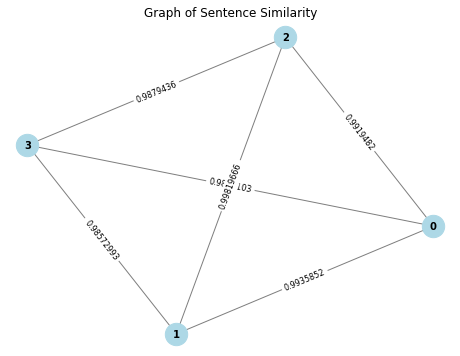

In [8]:
# Draw the graph
pos = nx.spring_layout(graph)
edge_labels = nx.get_edge_attributes(graph, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Graph of Sentence Similarity")
plt.axis('off')
plt.show()
